In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

### Define the target model architecture

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

Metal device set to: Apple M1 Pro


2022-05-13 11:37:26.390092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 11:37:26.390211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Now try the SafeKerasModel version

In [7]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [8]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekeras-test'}
- parameter optimizer = None identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.Nothing currently implemented to change type of parameter optimizer from NoneType to tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.



In [9]:
#safeModel.__dict__


In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [11]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_optimizer_is_DP(safeModel.optimizer)
print(f' It is {dpused} that the moddel will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the moddel will be DP because optimiser does  contain key _was_dp_gradients_called so should be DP.


Epoch 1/20


2022-05-13 11:37:26.650451: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 11:37:27.147907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 278ms/step - loss: 2.3861 - accuracy: 0.5360 - val_loss: 2.6914 - val_accuracy: 0.4640
Epoch 2/20


2022-05-13 11:37:30.065634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 273ms/step - loss: 1.9059 - accuracy: 0.6040 - val_loss: 2.3900 - val_accuracy: 0.5000
Epoch 3/20
10/10 [==============================] - 3s 276ms/step - loss: 1.5324 - accuracy: 0.6360 - val_loss: 2.2764 - val_accuracy: 0.5440
Epoch 4/20
10/10 [==============================] - 3s 272ms/step - loss: 1.3597 - accuracy: 0.6920 - val_loss: 2.2212 - val_accuracy: 0.5440
Epoch 5/20
10/10 [==============================] - 3s 276ms/step - loss: 1.1609 - accuracy: 0.7200 - val_loss: 2.0556 - val_accuracy: 0.5400
Epoch 6/20
10/10 [==============================] - 3s 277ms/step - loss: 0.9064 - accuracy: 0.7640 - val_loss: 2.0575 - val_accuracy: 0.5600
Epoch 7/20
10/10 [==============================] - 3s 307ms/step - loss: 0.8158 - accuracy: 0.7880 - val_loss: 2.0412 - val_accuracy: 0.5680
Epoch 8/20
10/10 [==============================] - 3s 277ms/step - loss: 0.7182 - accuracy: 0.8120 - val_loss: 2.0571 - val_accuracy: 0.5840
Epoch 9/20
10/10 

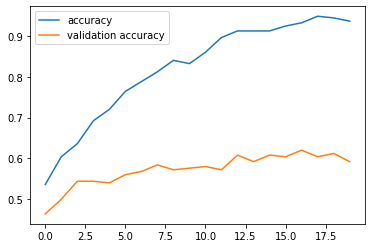

In [12]:
epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show() 


In [13]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_DP_used(safeModel.optimizer)
print(f' It is {dpused} that the moddel will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the moddel will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimiser has been run


## compute privacy

In [16]:
print(f'dataset has {Xt.shape[0]} entries so batch size is {100*safeModel.batch_size/Xt.shape[0]}%')
privacy = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=safeModel.batch_size,
                                              noise_multiplier=safeModel.noise_multiplier,
                                              epochs=25,#epochs,
                                              delta=1e-5)
print(f'with these settings privacy = {privacy}')

dataset has 500 entries so batch size is 5.0%
DP-SGD with sampling rate = 5% and noise_multiplier = 0.5 iterated over 500 steps satisfies differential privacy with eps = 43.9 and delta = 1e-05.
The optimal RDP order is 1.5.
with these settings privacy = (43.852285895654624, 1.5)


In [18]:
safeModel.save('safekeras.sav')

INFO:tensorflow:Assets written to: safekeras.sav/assets


2022-05-13 12:07:08.356706: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
safeModel.preliminary_check()

- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x28fe30100> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.


('WARNING: model parameters may present a disclosure risk:\n- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x28fe30100> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.',
 True)

In [20]:
safeModel.request_release('safekeras.pkl')

INFO:tensorflow:Assets written to: safekeras.pkl/assets


AttributeError: type object 'super' has no attribute 'posthoc'

In [17]:
for key,value in safeModel.__dict__.items():
    print(key,value)

_self_setattr_tracking True
_obj_reference_counts_dict ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>>: 1, <_ObjectIdentityWrapper wrapping <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping 'j4-smith'>: 1, <_ObjectIdentityWrapper wrapping 'KerasModel'>: 1, <_ObjectIdentityWrapper wrapping 25>: 1, <_ObjectIdentityWrapper wrapping 1.0>: 1, <_ObjectIdentityWrapper wrapping 0.5>: 1, <_ObjectIdentityWrapper wrapping 0.1>: 1, <_ObjectIdentityWrapper wrapping <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x28fe30100>>: 1, <_ObjectIdentityWrapper wrapping <keras.engine.compile_utils.LossesContainer object at 0x28fe307c0>>: 1, <_ObjectIdentityWrapper wrapping <keras.e

In [ ]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeKerasModel1 = Safe_KerasModel(input_data, output)
safeKerasModel1.compile()
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save(name="safe1.pkl")
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(input_data, output)
safeKerasModel2.compile()
safeKerasModel2.optimizer="DPAdam"
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel2.save(name="safe2.pkl")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.pkl")

# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel3 = Safe_KerasModel(input_data, output)
safeKerasModel3.compile()
safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save(name="unsafe3.pkl")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.pkl")

# change another model params in an  unsafe way


# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")


In [ ]:
# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(input_data, output)
safeKerasModel6.compile()
safeKerasModel6.optimizer="Adam"
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save(name="unsafe6.pkl")
safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.pkl")